In [1]:
import nltk
!rm -rf /usr/share/nltk_data/corpora/wordnet
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [2]:
# Import basic libraries
import string
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn            #Base class for all neural network modules
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.scripts.glove2word2vec import glove2word2vec
import optuna
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, auc
from tqdm import tqdm
from sklearn import metrics
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Random Seed at file level for reproducibility
random_seed = 137

np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)  # we add torch seed
torch.cuda.manual_seed(random_seed)
# When running on the CuDNN backend, two further options must be set
torch.backends.cudnn.deterministic = True
# Set a fixed value for the hash seed
os.environ['PYTHONHASHSEED'] = str(random_seed)
torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)

In [ ]:
# Import the data
df_train = pd.read_csv('YOUR PATH TO: train_dataset.csv')    # returns a dataframe
df_val = pd.read_csv('YOUR PATH TO: val_dataset.csv')
df_test = pd.read_csv('YOUR PATH TO: test_dataset.csv')

In [6]:
X_train, y_train = df_train["Text"], df_train["Label"]    # corresponds tuples
X_val, y_val = df_val["Text"], df_val["Label"]
X_test, X_test_id = df_test["Text"], df_test["ID"]

In [7]:
# Preprocessing (all the functions we'll need):
# We tokenize, so that we can preprocess
def my_split(str_arg):
    return str_arg.split(' ')

# lowercase
def my_lower(list_arg):
    length = len(list_arg)
    for i in range(length):
        list_arg[i] = list_arg[i].lower()
    return list_arg

# stop word removal
def my_stopword(list_arg):
    clean_list = []
    for word in list_arg:
        if word not in stopwords.words('english'):
            clean_list.append(word)
    return clean_list

# Lemmatization.
def my_lemmatize(list_arg):
    lemmatizer = WordNetLemmatizer()
    length = len(list_arg)
    for i in range(length):
        list_arg[i] = lemmatizer.lemmatize(list_arg[i])
    return list_arg

# Remove special characters and punctuation
def my_unpunct(list_arg):
    length = len(list_arg)
    for i in range(length):
        list_arg[i] = ''.join([ch for ch in list_arg[i] if ch not in string.punctuation])
    return list_arg

def my_join(list_arg):
    return " ".join(list_arg)    # this is a string function

def my_preprocess(X_set):
    # See report on why certain functions are commented!
    X_set = X_set.apply(my_split)       # we tokenize, so that we can preprocess
    X_set = X_set.apply(my_lower)       # we lowercase
    # X_set = X_set.apply(my_stopword)    # we remove stop words
    # X_set = X_set.apply(my_lemmatize)   # we lemmatize
    X_set = X_set.apply(my_unpunct)     # we remove special characters and punctuation 
    X_set = X_set.apply(my_join)        # we join all the tokens of one sentence together
    return X_set

In [8]:
# We preprocess train, validation and test set
X_train = my_preprocess(X_train)
X_val = my_preprocess(X_val)
X_test = my_preprocess(X_test)

In [9]:
# Download GloVe Embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip

--2025-05-05 15:33:23--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-05 15:33:24--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-05 15:33:24--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [10]:
# Transform GloVe embeddings to Word2Vec format
# GLOVE_TYPE = 'glove.6B.'            # d = {50, 100, 200, 300}
GLOVE_TYPE = 'glove.twitter.27B.'   # d = {25, 50, 200}
DIMENSIONS = 200

glove_input_file = GLOVE_TYPE + str(DIMENSIONS) +'d.txt'
w2v_output_file = 'glv_with_w2v_format.txt'

glove2word2vec(glove_input_file, w2v_output_file) #convert GloVe vectors into the word2vec

<ipython-input-10-132f93a6351f>:9: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, w2v_output_file) #convert GloVe vectors into the word2vec


(1193514, 200)

In [11]:
# We create a dictionary 'word' -> 'vector of floats, dimension = 50' of w2vec embeddings
with open(w2v_output_file, 'r') as my_file:   # 'with' statement, closes the file for you
    w2v_list_str = my_file.read().splitlines()   # splitlines() splits a string into a list

w2v_dict = {}    # word_str -> vector_float_list

# w2v_list_str is a list of strings, word_vector_pair_str is a class str
# first string of w2v_list_str is: 400000 50 (where 400000 + 1 is size of list, and 50 is the dimension of each vector), second string is: the 0.418 0.24968 -0.41242 ...
for word_vector_pair_str in w2v_list_str[1:]:
    word_vector_pair_list_str = word_vector_pair_str.split() # Converts a string like "apple 0.1 0.2 0.3" into a list: ['apple', '0.1', '0.2', '0.3']
    if(len(word_vector_pair_list_str) == 0):   # empty list, which means empty line (most likely last line of file)
        continue
    word_str = word_vector_pair_list_str[0]   # 'apple'
    vector_str_list = word_vector_pair_list_str[1:]   # ['0.1', '0.2', '0.3']
    
    vector_float_list = []
    for number_str in vector_str_list:
        number_float = float(number_str)    # Converts text numbers (like '0.123') to actual numbers (like 0.123)
        vector_float_list.append(number_float)
        
    w2v_dict[word_str] = vector_float_list

In [12]:
# We write the functions that find the w2vec representation of a tweet
def my_split(str_arg):
    return str_arg.split(' ')

def my_add_vector(vector_sum, vector_float_list):   # vector_sum is of size 50, so is vector_float_list
    index = 0
    for number_float in vector_float_list:
        vector_sum[index] = vector_sum[index] + number_float
        index += 1
    return vector_sum

def my_constant_mult_vector(vector_sum, constant):
    new_vector_sum = []
    for number_float in vector_sum:
        new_vector_sum.append(number_float * constant)
    return new_vector_sum
    
def my_average(str_list):
    vector_sum = [0] * DIMENSIONS
    count = 0
    for word_str in str_list:
        if word_str in w2v_dict:
            vector_float_list = w2v_dict[word_str]
            vector_sum = my_add_vector(vector_sum, vector_float_list)
            count += 1
    if count == 0:
        return vector_sum  # Or handle zero case separately
    vector_average = my_constant_mult_vector(vector_sum, 1/count)
    return vector_average

def my_embed(X_set):
    X_set_temp = X_set.apply(my_split)
    X_set_temp = X_set_temp.apply(my_average)
    return X_set_temp

In [13]:
# We embed our tweets and save them in tensors
X_train_embedded = my_embed(X_train)
X_val_embedded = my_embed(X_val)      # guess needed
X_test_embedded = my_embed(X_test)    # guess needed

print(X_train_embedded)

X_train_tensor = torch.tensor(X_train_embedded, dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).to(device)
X_val_tensor = torch.tensor(X_val_embedded, dtype=torch.float).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float).to(device)
X_test_tensor = torch.tensor(X_test_embedded, dtype=torch.float).to(device)

0         [0.06258449999999999, 0.07883671666666665, -0....
1         [0.023130346153846154, -2.692307692297041e-07,...
2         [-0.08837590000000001, 0.06391220000000002, 0....
3         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4         [0.039743938095238095, 0.13998883419047617, 0....
                                ...                        
148383    [0.13062405, 0.22433193750000002, -0.026162999...
148384    [0.22554602857142853, 0.058073714285714284, -0...
148385    [-0.16714468857142856, -0.005584285714285724, ...
148386    [0.07385898333333331, 0.16396233333333332, 0.1...
148387    [-0.025244428571428567, 0.05163921428571429, 0...
Name: Text, Length: 148388, dtype: object


In [14]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_sizes, output_dim, dropout_rate, apply_sigmoid):
        super(Net, self).__init__()
        layers = []
        in_dim = input_dim
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_dim, hidden_size))
            layers.append(nn.ReLU())    # we apply the same activation function to each layer, we append the activation, just after we initialize the hidden layer, so that it is applied
            layers.append(nn.Dropout(dropout_rate))
            in_dim = hidden_size
        layers.append(nn.Linear(in_dim, output_dim))    # Final output layer
        self.model = nn.Sequential(*layers)
        self.apply_sigmoid = apply_sigmoid
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.model(x)          # Pass input through all layers in self.model
        if(self.apply_sigmoid == 1):
            out = self.sigmoid(out)  # Apply sigmoid to the output layer (BCELoss expects probabilites as input, BCEWithLogitsLoss expects Logits as input)
        return out

In [15]:
# Baseline model (27B.200d and my_lower, my_unpunct only enabled in preprocessing)
hidden_sizes = [64]
learning_rate = 5e-4
no_epochs = 100
loss_func = nn.BCELoss()
batch_size = 64
activation = "ReLU"
apply_sigmoid = 1                   # 1 stands for 'YES' and is for BCELoss
dropout_rate = 0.0

# We initialize the model
D_in = X_train_tensor.shape[1]
D_out = 1
model = Net(D_in, hidden_sizes, D_out, dropout_rate, apply_sigmoid).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

print(model)
    
# Initialise dataloader
dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor) #class to represent the data as list of tensors. x=input_features, y=labels
dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)  # shuffle=True, to have the data reshuffled at every epoch

# Train network
epochs = []
loss_training = []
loss_validation = []
accuracy_training = []
accuracy_validation = []
best_val_accuracy = 0.0
best_epoch = -1
for epoch in range(no_epochs):
    model.train()
    batch_losses = []

    for x_batch, y_batch in dataloader:   # we traverse batches (first batch #1, then batch #2, etc)
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch)
        loss = loss_func(torch.flatten(y_pred), y_batch)   # y_batch is size [64], whereas y_pred is size [64,1]. torch.flatten reshapes into a one-dimensional tensor
        # loss is a number
        
        no_samples = x_batch.shape[0]
        sum_loss_this_batch = loss * no_samples
        batch_losses.append(sum_loss_this_batch.item()) # tensor.item = Returns the value of this tensor as a standard Python number. This only works for tensors with one element.
        #Delete previously stored gradients
        optimizer.zero_grad()   # Reset the gradients of all optimized torch.Tensor s. (this is a function of torch.optim.<optimizer>.)
        #Perform backpropagation starting from the loss calculated in this epoch
        loss.backward()    # loss function returned us a tensor. in that tensor, we call backward (Computes the gradient of current tensor wrt graph leaves.The graph is differentiated using the chain rule. If the tensor is non-scalar (i.e. its data has more than one element) and requires gradient, the function additionally requires specifying a gradient. It should be a tensor of matching type and shape, that represents the gradient of the differentiated function w.r.t. self. This function accumulates gradients in the leaves - you might need to zero .grad attributes or set them to None before calling it. )
        #Update model's weights based on the gradients calculated during backprop
        optimizer.step()      # Perform a single optimization step.  (this is a function of torch.optim.<optimizer>.)
        
    model.eval()
    with torch.no_grad():   # we disable gradient tracking during validation to save memory
        y_val_pred = model(X_val_tensor)
        loss_val = loss_func(y_val_pred.flatten(), y_val_tensor)    # loss val is a tensor scalar (can't call tensor.item cause this is for tensors with one element)
        loss_val = loss_val.cpu().detach().numpy()   # we convert loss_val to scalar
        loss_validation.append(loss_val)   # loss_val is a tensor scalar

        # if BCEWithLogitsLoss used, should apply sigmoid to output, before calculating accuracy
        if isinstance(loss_func, nn.BCEWithLogitsLoss):
            y_val_pred = torch.sigmoid(y_val_pred)
        y_val_pred = y_val_pred.round().cpu().detach().numpy().flatten()  # NUMPY FLATTEN        
        accuracy = accuracy_score(y_val, y_val_pred)
        epoch_loss = sum(batch_losses)/len(X_train)
        
        epochs.append(epoch)
        loss_training.append(epoch_loss)
        accuracy_validation.append(accuracy)

        print(f"Epoch {epoch}: loss_train = {epoch_loss:.5f}, loss_val = {loss_val:.5f}, accuracy_val = {accuracy:.5f}")

        y_train_pred = model(X_train_tensor)
        if isinstance(loss_func, nn.BCEWithLogitsLoss):
            y_train_pred = torch.sigmoid(y_train_pred) 
        y_train_pred = y_train_pred.round()
        y_train_pred = torch.flatten(y_train_pred)
        y_train_pred = y_train_pred.cpu().detach().numpy()
        y_train_pred = y_train_pred.astype(np.int64)
        accuracy_train = accuracy_score(y_train, y_train_pred)
        accuracy_training.append(accuracy_train)

        if(accuracy > best_val_accuracy):
            best_val_accuracy = accuracy
            best_epoch = epoch

print("Best val_accuracy of all epochs = ", best_val_accuracy, " in epoch = ", best_epoch)

Net(
  (model): Sequential(
    (0): Linear(in_features=200, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)
Epoch 0: loss_train = 0.51230, loss_val = 0.48356, accuracy_val = 0.76665
Epoch 1: loss_train = 0.48363, loss_val = 0.47644, accuracy_val = 0.76948
Epoch 2: loss_train = 0.47713, loss_val = 0.47210, accuracy_val = 0.77196
Epoch 3: loss_train = 0.47266, loss_val = 0.46817, accuracy_val = 0.77399
Epoch 4: loss_train = 0.46912, loss_val = 0.46752, accuracy_val = 0.77500
Epoch 5: loss_train = 0.46598, loss_val = 0.46895, accuracy_val = 0.77406
Epoch 6: loss_train = 0.46310, loss_val = 0.46372, accuracy_val = 0.77717
Epoch 7: loss_train = 0.46091, loss_val = 0.46452, accuracy_val = 0.77776
Epoch 8: loss_train = 0.45880, loss_val = 0.46307, accuracy_val = 0.77805
Epoch 9: loss_train = 0.45657, loss_val = 0.46169, accuracy_val = 0.77774
Epoch 10: loss_train = 0.454

In [16]:
# We calculate accuracy of validation set (baseline model)
model.eval()
with torch.no_grad():
    y_val_pred = model(X_val_tensor)
    if isinstance(loss_func, nn.BCEWithLogitsLoss):
        y_val_pred = torch.sigmoid(y_val_pred)
    y_val_pred = torch.flatten(y_val_pred).round().cpu().detach().numpy()

accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy in val_set: {accuracy: .6f}")

Accuracy in val_set:  0.776017


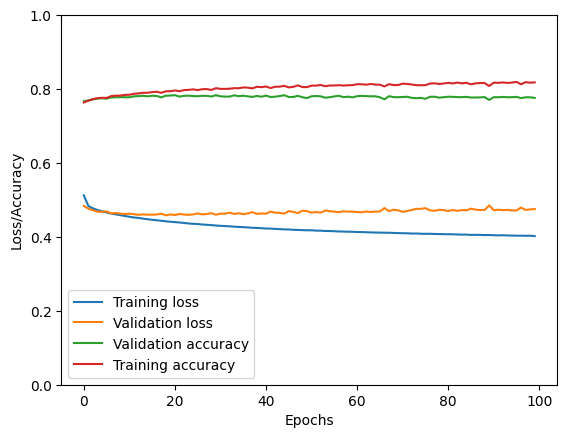

In [17]:
# plotting the points (baseline model)
plt.ylim(0, 1)      # Θέλουμε ο άξονας y που είναι το accuracy να ξεκινά από το μηδέν και να φτάνει μέχρι το ένα

plt.plot(epochs, loss_training, label="Training loss")  
plt.plot(epochs, loss_validation, label="Validation loss")  
plt.plot(epochs, accuracy_validation, label="Validation accuracy")  
plt.plot(epochs, accuracy_training, label="Training accuracy")  
    
plt.xlabel('Epochs')  # naming the x axis  
plt.ylabel('Loss/Accuracy')       # naming the y axis  

plt.legend()
plt.savefig('learning-curve-baseline.png')

In [18]:
# accuracy, recall, precision, f1 score (baseline model)
print("Classification Report:\n", classification_report(y_val, y_val_pred)) 

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.81      0.78     21197
           1       0.80      0.74      0.77     21199

    accuracy                           0.78     42396
   macro avg       0.78      0.78      0.78     42396
weighted avg       0.78      0.78      0.78     42396



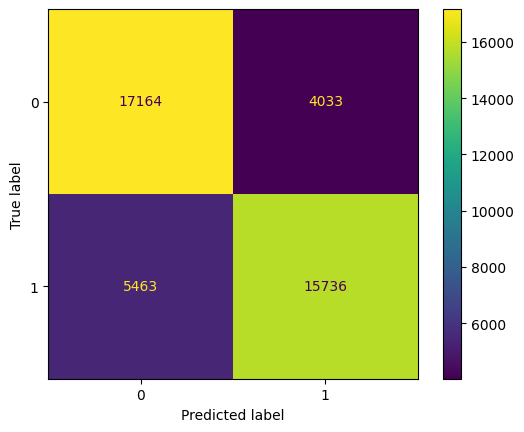

In [19]:
#confusion matrix (baseline model)
confusion_matrix = metrics.confusion_matrix(y_val, y_val_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1]) 
cm_display.plot()
plt.savefig('confusion-matrix-baseline.png')

In [20]:
# Best model
hidden_sizes = [400]
learning_rate = 0.0006948140681022177
no_epochs = 51
loss_func = nn.BCELoss()
batch_size = 1024
activation = "ReLU"
apply_sigmoid = 1                   # 1 stands for 'YES' and is for BCELoss
dropout_rate = 0.4529273673532248

# We initialize the model
D_in = X_train_tensor.shape[1]
D_out = 1
model = Net(D_in, hidden_sizes, D_out, dropout_rate, apply_sigmoid).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

print(model)
    
# Initialise dataloader
dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor) #class to represent the data as list of tensors. x=input_features, y=labels
dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)  # shuffle=True, to have the data reshuffled at every epoch

# Train network
epochs = []
loss_training = []
loss_validation = []
accuracy_training = []
accuracy_validation = []
best_val_accuracy = 0.0
best_epoch = -1
for epoch in range(no_epochs):
    model.train()
    batch_losses = []

    for x_batch, y_batch in dataloader:   # we traverse batches (first batch #1, then batch #2, etc)
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch)
        loss = loss_func(torch.flatten(y_pred), y_batch)   # y_batch is size [64], whereas y_pred is size [64,1]. torch.flatten reshapes into a one-dimensional tensor
        # loss is a number
        
        no_samples = x_batch.shape[0]
        sum_loss_this_batch = loss * no_samples
        batch_losses.append(sum_loss_this_batch.item()) # tensor.item = Returns the value of this tensor as a standard Python number. This only works for tensors with one element.
        #Delete previously stored gradients
        optimizer.zero_grad()   # Reset the gradients of all optimized torch.Tensor s. (this is a function of torch.optim.<optimizer>.)
        #Perform backpropagation starting from the loss calculated in this epoch
        loss.backward()    # loss function returned us a tensor. in that tensor, we call backward (Computes the gradient of current tensor wrt graph leaves.The graph is differentiated using the chain rule. If the tensor is non-scalar (i.e. its data has more than one element) and requires gradient, the function additionally requires specifying a gradient. It should be a tensor of matching type and shape, that represents the gradient of the differentiated function w.r.t. self. This function accumulates gradients in the leaves - you might need to zero .grad attributes or set them to None before calling it. )
        #Update model's weights based on the gradients calculated during backprop
        optimizer.step()      # Perform a single optimization step.  (this is a function of torch.optim.<optimizer>.)
        
    model.eval()
    with torch.no_grad():   # we disable gradient tracking during validation to save memory
        y_val_pred = model(X_val_tensor)
        loss_val = loss_func(y_val_pred.flatten(), y_val_tensor)    # loss val is a tensor scalar (can't call tensor.item cause this is for tensors with one element)
        loss_val = loss_val.cpu().detach().numpy()   # we convert loss_val to scalar
        loss_validation.append(loss_val)   # loss_val is a tensor scalar

        # if BCEWithLogitsLoss used, should apply sigmoid to output, before calculating accuracy
        if isinstance(loss_func, nn.BCEWithLogitsLoss):
            y_val_pred = torch.sigmoid(y_val_pred)
        y_val_pred = y_val_pred.round().cpu().detach().numpy().flatten()  # NUMPY FLATTEN        
        accuracy = accuracy_score(y_val, y_val_pred)
        epoch_loss = sum(batch_losses)/len(X_train)
        
        epochs.append(epoch)
        loss_training.append(epoch_loss)
        accuracy_validation.append(accuracy)

        print(f"Epoch {epoch}: loss_train = {epoch_loss:.5f}, loss_val = {loss_val:.5f}, accuracy_val = {accuracy:.5f}")

        y_train_pred = model(X_train_tensor)
        if isinstance(loss_func, nn.BCEWithLogitsLoss):
            y_train_pred = torch.sigmoid(y_train_pred) 
        y_train_pred = y_train_pred.round()
        y_train_pred = torch.flatten(y_train_pred)
        y_train_pred = y_train_pred.cpu().detach().numpy()
        y_train_pred = y_train_pred.astype(np.int64)
        accuracy_train = accuracy_score(y_train, y_train_pred)
        accuracy_training.append(accuracy_train)

        if(accuracy > best_val_accuracy):
            best_val_accuracy = accuracy
            best_epoch = epoch

print("Best val_accuracy of all epochs = ", best_val_accuracy, " in epoch = ", best_epoch)

Net(
  (model): Sequential(
    (0): Linear(in_features=200, out_features=400, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4529273673532248, inplace=False)
    (3): Linear(in_features=400, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)
Epoch 0: loss_train = 0.54842, loss_val = 0.49099, accuracy_val = 0.76142
Epoch 1: loss_train = 0.49318, loss_val = 0.47988, accuracy_val = 0.76873
Epoch 2: loss_train = 0.48463, loss_val = 0.47483, accuracy_val = 0.76995
Epoch 3: loss_train = 0.47943, loss_val = 0.47211, accuracy_val = 0.77057
Epoch 4: loss_train = 0.47603, loss_val = 0.46946, accuracy_val = 0.77422
Epoch 5: loss_train = 0.47265, loss_val = 0.46648, accuracy_val = 0.77453
Epoch 6: loss_train = 0.47046, loss_val = 0.46543, accuracy_val = 0.77453
Epoch 7: loss_train = 0.46794, loss_val = 0.46322, accuracy_val = 0.77717
Epoch 8: loss_train = 0.46487, loss_val = 0.46213, accuracy_val = 0.77717
Epoch 9: loss_train = 0.46324, loss_val = 0.46150, accuracy_val = 0.77906
Epoch 10: l

In [21]:
# We calculate accuracy of validation set (best model)
model.eval()
with torch.no_grad():
    y_val_pred = model(X_val_tensor)
    if isinstance(loss_func, nn.BCEWithLogitsLoss):
        y_val_pred = torch.sigmoid(y_val_pred)
    y_val_pred = torch.flatten(y_val_pred).round().cpu().detach().numpy()

accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy in val_set: {accuracy: .6f}")

Accuracy in val_set:  0.788730


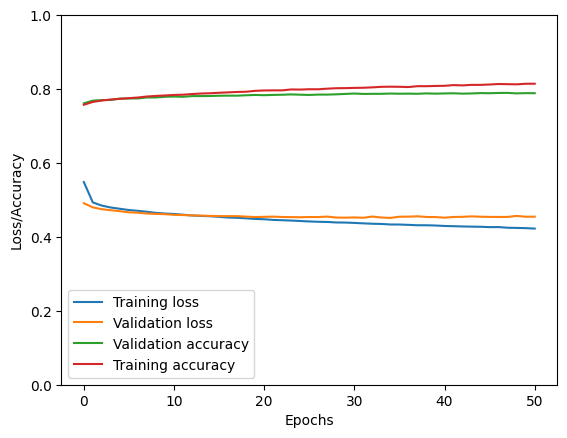

In [22]:
# plotting the points (best model)
plt.ylim(0, 1)      # Θέλουμε ο άξονας y που είναι το accuracy να ξεκινά από το μηδέν και να φτάνει μέχρι το ένα

plt.plot(epochs, loss_training, label="Training loss")  
plt.plot(epochs, loss_validation, label="Validation loss")  
plt.plot(epochs, accuracy_validation, label="Validation accuracy")  
plt.plot(epochs, accuracy_training, label="Training accuracy")  
    
plt.xlabel('Epochs')  # naming the x axis  
plt.ylabel('Loss/Accuracy')       # naming the y axis  

plt.legend()
plt.savefig('learning-curve-final.png')

In [23]:
# accuracy, recall, precision, f1 score (best model)
print("Classification Report:\n", classification_report(y_val, y_val_pred)) 

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.81      0.79     21197
           1       0.80      0.77      0.78     21199

    accuracy                           0.79     42396
   macro avg       0.79      0.79      0.79     42396
weighted avg       0.79      0.79      0.79     42396



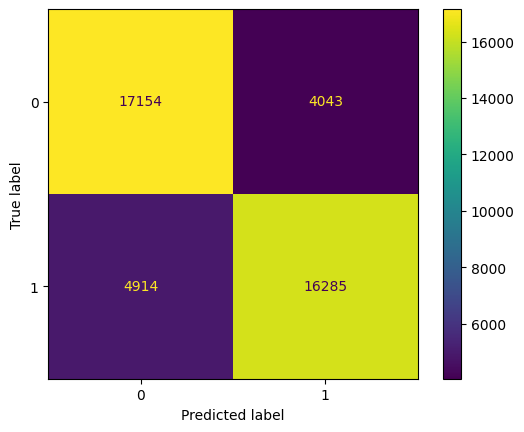

In [24]:
#confusion matrix (best model)
confusion_matrix = metrics.confusion_matrix(y_val, y_val_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1]) 
cm_display.plot()
plt.savefig('confusion-matrix-final.png')

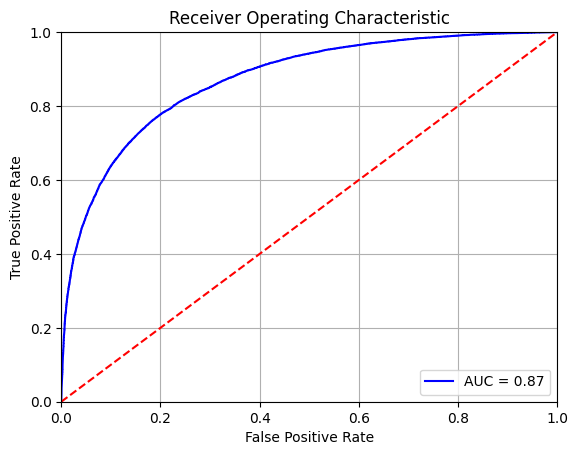

In [25]:
# ROC curve (best model)
model.eval()
with torch.no_grad():
    y_prob = model(X_val_tensor)
    if isinstance(loss_func, nn.BCEWithLogitsLoss):
        y_prob = torch.sigmoid(y_prob)
    y_prob = y_prob.cpu().numpy().flatten()

fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.grid(True)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('roc-curve-final.png')

In [26]:
# Sumbmit test set
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor)
    if isinstance(loss_func, nn.BCEWithLogitsLoss):
        y_test_pred = torch.sigmoid(y_test_pred)
    y_test_pred = torch.flatten(y_test_pred).round().cpu().detach().numpy()
    y_test_pred = y_test_pred.astype(np.int64)

df_test_submission = pd.DataFrame({'ID': X_test_id, 'Label' : y_test_pred})
df_test_submission.to_csv('submission.csv', index=False)

In [27]:
# # OPTUNA FOR 1 HIDDEN LAYER (implements early stopping):
# def objective(trial):
#     # Number of hidden layers
#     n_hidden_layers = 1
    
#     # Number of neurons for each hidden layer
#     hidden_sizes = []
#     for i in range(n_hidden_layers):
#         hidden_size = trial.suggest_categorical(f"hidden_size_{i}", [50, 100, 200, 300, 400])  # known από θεωρία
#         hidden_sizes.append(hidden_size)

#     # More hyperparameters
#     optimizer_name = trial.suggest_categorical("optimizer_name", ["AdamW", "NAdam", "SGD"])
#     learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-3, log=True)
#     no_epochs = trial.suggest_categorical("epochs", [10, 100, 300])  # big learning rate, means lower no_epochs to avoid overfitting
#     loss_func = trial.suggest_categorical("loss_func", ["BCELoss", "BCEWithLogitsLoss"])
#     batch_size = 1024
#     dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
#     activation = "RELU"

#     # Our dataset is balanced, so no need to pass a weight to loss functions
#     apply_sigmoid = 0                   # 0 stands for 'NO'
#     if loss_func == "BCELoss":
#         loss_func = nn.BCELoss()        # we use reduction='mean'
#         apply_sigmoid = 1               # 1 stands for 'YES'
#     else:
#         loss_func = nn.BCEWithLogitsLoss()    # sigmoid is applied after BCELoss
        
#     # We initialize the model
#     D_in = X_train_tensor.shape[1]
#     D_out = 1
#     model = Net(D_in, hidden_sizes, D_out, dropout_rate, apply_sigmoid).to(device)

#     if optimizer_name == "AdamW":
#         optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#     elif optimizer_name == "NAdam": 
#         optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)
#     else:
#         optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#     #Initialise dataloader
#     dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor) #class to represent the data as list of tensors. x=input_features, y=labels
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)  # batch_size = 64, shuffle=True, to have the data reshuffled at every epoch

#     # Train network
#     patience = 5                    # how many epochs to wait for improvement
#     epochs_no_improve = 0
#     best_val_accuracy = 0.0
#     best_epoch = -1
#     for epoch in range(no_epochs):
#       model.train()
#       batch_losses = []
    
#       for x_batch, y_batch in dataloader:   # we traverse batches (first batch #1, then batch #2, etc)
#         x_batch, y_batch = x_batch.to(device), y_batch.to(device)
#         y_pred = model(x_batch)
          
#         loss = loss_func(torch.flatten(y_pred), y_batch)   # y_batch is size [64], whereas y_pred is size [64,1]. torch.flatten reshapes into a one-dimensional tensor
#         # loss is a number
    
#         no_samples = x_batch.shape[0]
#         sum_loss_this_batch = loss * no_samples
#         batch_losses.append(sum_loss_this_batch.item()) # tensor.item = Returns the value of this tensor as a standard Python number. This only works for tensors with one element.
#         #Delete previously stored gradients
#         optimizer.zero_grad()   # Reset the gradients of all optimized torch.Tensor s. (this is a function of torch.optim.<optimizer>.)
#         #Perform backpropagation starting from the loss calculated in this epoch
#         loss.backward()    # loss function returned us a tensor. in that tensor, we call backward (Computes the gradient of current tensor wrt graph leaves.The graph is differentiated using the chain rule. If the tensor is non-scalar (i.e. its data has more than one element) and requires gradient, the function additionally requires specifying a gradient. It should be a tensor of matching type and shape, that represents the gradient of the differentiated function w.r.t. self. This function accumulates gradients in the leaves - you might need to zero .grad attributes or set them to None before calling it. )
#         #Update model's weights based on the gradients calculated during backprop
#         optimizer.step()      # Perform a single optimization step.  (this is a function of torch.optim.<optimizer>.)

#       epoch_loss = sum(batch_losses)/len(X_train)

#       model.eval()   # we set model to evaluation mode -> we disable dropout

#       with torch.no_grad():    # we disable gradient tracking during validation to save memory
#         y_val_pred = model(X_val_tensor)
#         loss_val = loss_func(y_val_pred.flatten(), y_val_tensor)    # loss val is a tensor scalar (can't call tensor.item cause this is for tensors with one element)
#         loss_val = loss_val.cpu().detach().numpy()   # we convert loss_val to scalar

#         # if BCEWithLogitsLoss used, should apply sigmoid to output, before calculating accuracy
#         if isinstance(loss_func, nn.BCEWithLogitsLoss):
#             y_val_pred = torch.sigmoid(y_val_pred)
#         y_val_pred = y_val_pred.round().cpu().detach().numpy().flatten()  # NUMPY FLATTEN
#         accuracy = accuracy_score(y_val, y_val_pred)

#         print(f"Epoch {epoch}: loss_train = {epoch_loss:.5f}, loss_val = {loss_val:.5f}, accuracy_val = {accuracy:.5f}")

#         if(accuracy > best_val_accuracy):
#             best_val_accuracy = accuracy
#             best_epoch = epoch
#             epochs_no_improve = 0
#         else:
#             epochs_no_improve += 1

#         if epochs_no_improve >= patience:
#                 print(f"Early stopping at epoch {epoch}")
#                 break  # Stop training


#     print("Best val_accuracy of all epochs = ", best_val_accuracy, " in epoch = ", best_epoch)
#     return best_val_accuracy
#     # return sum(accuracies_val)/len(accuracies_val) # return value of this function, is the metric we want to optimize   # *** CHANGED THIS


# optuna_sample = optuna.create_study(direction = 'maximize', study_name = 'lr-minim-sample')    # *** CHANGED THIS
# optuna_sample.optimize(objective, n_jobs=1) # optuna will run #the first parameter is the function that we want to optimise (It runs the objective function for 50 different trials. In each trial, Optuna samples a new set of hyperparameters according to the ranges and categories you specified.)
# print('numbers of the finished trials:' , len(optuna_sample.trials))   
# print('the best params:' , optuna_sample.best_trial.params)
# print('the best value:' , optuna_sample.best_value)

In [28]:
# # OPTUNA FOR 3 HIDDEN LAYERS (implements early stopping):
# def objective(trial):
#     # Number of hidden layers
#     n_hidden_layers = 3
    
#     # Number of neurons for each hidden layer
#     hidden_sizes = []
#     for i in range(n_hidden_layers):
#         hidden_size = trial.suggest_categorical(f"hidden_size_{i}", [50, 100, 200, 300, 400])  # known από θεωρία
#         hidden_sizes.append(hidden_size)

#     # More hyperparameters
#     optimizer_name = trial.suggest_categorical("optimizer_name", ["AdamW", "NAdam", "SGD"])
#     learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-3, log=True)
#     no_epochs = trial.suggest_categorical("epochs", [10, 100, 300])  # big learning rate, means lower no_epochs to avoid overfitting
#     loss_func = trial.suggest_categorical("loss_func", ["BCELoss", "BCEWithLogitsLoss"])
#     batch_size = 1024
#     dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
#     activation = "RELU"

#     # Our dataset is balanced, so no need to pass a weight to loss functions
#     apply_sigmoid = 0                   # 0 stands for 'NO'
#     if loss_func == "BCELoss":
#         loss_func = nn.BCELoss()        # we use reduction='mean'
#         apply_sigmoid = 1               # 1 stands for 'YES'
#     else:
#         loss_func = nn.BCEWithLogitsLoss()    # sigmoid is applied after BCELoss
        
#     # We initialize the model
#     D_in = X_train_tensor.shape[1]
#     D_out = 1
#     model = Net(D_in, hidden_sizes, D_out, dropout_rate, apply_sigmoid).to(device)

#     if optimizer_name == "AdamW":
#         optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#     elif optimizer_name == "NAdam": 
#         optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)
#     else:
#         optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#     #Initialise dataloader
#     dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor) #class to represent the data as list of tensors. x=input_features, y=labels
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)  # batch_size = 64, shuffle=True, to have the data reshuffled at every epoch

#     # Train network
#     patience = 5                    # how many epochs to wait for improvement
#     epochs_no_improve = 0
#     best_val_accuracy = 0.0
#     best_epoch = -1
#     for epoch in range(no_epochs):
#       model.train()
#       batch_losses = []
    
#       for x_batch, y_batch in dataloader:   # we traverse batches (first batch #1, then batch #2, etc)
#         x_batch, y_batch = x_batch.to(device), y_batch.to(device)
#         y_pred = model(x_batch)
          
#         loss = loss_func(torch.flatten(y_pred), y_batch)   # y_batch is size [64], whereas y_pred is size [64,1]. torch.flatten reshapes into a one-dimensional tensor
#         # loss is a number
    
#         no_samples = x_batch.shape[0]
#         sum_loss_this_batch = loss * no_samples
#         batch_losses.append(sum_loss_this_batch.item()) # tensor.item = Returns the value of this tensor as a standard Python number. This only works for tensors with one element.
#         #Delete previously stored gradients
#         optimizer.zero_grad()   # Reset the gradients of all optimized torch.Tensor s. (this is a function of torch.optim.<optimizer>.)
#         #Perform backpropagation starting from the loss calculated in this epoch
#         loss.backward()    # loss function returned us a tensor. in that tensor, we call backward (Computes the gradient of current tensor wrt graph leaves.The graph is differentiated using the chain rule. If the tensor is non-scalar (i.e. its data has more than one element) and requires gradient, the function additionally requires specifying a gradient. It should be a tensor of matching type and shape, that represents the gradient of the differentiated function w.r.t. self. This function accumulates gradients in the leaves - you might need to zero .grad attributes or set them to None before calling it. )
#         #Update model's weights based on the gradients calculated during backprop
#         optimizer.step()      # Perform a single optimization step.  (this is a function of torch.optim.<optimizer>.)

#       epoch_loss = sum(batch_losses)/len(X_train)

#       model.eval()   # we set model to evaluation mode -> we disable dropout

#       with torch.no_grad():    # we disable gradient tracking during validation to save memory
#         y_val_pred = model(X_val_tensor)
#         loss_val = loss_func(y_val_pred.flatten(), y_val_tensor)    # loss val is a tensor scalar (can't call tensor.item cause this is for tensors with one element)
#         loss_val = loss_val.cpu().detach().numpy()   # we convert loss_val to scalar

#         # if BCEWithLogitsLoss used, should apply sigmoid to output, before calculating accuracy
#         if isinstance(loss_func, nn.BCEWithLogitsLoss):
#             y_val_pred = torch.sigmoid(y_val_pred)
#         y_val_pred = y_val_pred.round().cpu().detach().numpy().flatten()  # NUMPY FLATTEN
#         accuracy = accuracy_score(y_val, y_val_pred)

#         print(f"Epoch {epoch}: loss_train = {epoch_loss:.5f}, loss_val = {loss_val:.5f}, accuracy_val = {accuracy:.5f}")

#         if(accuracy > best_val_accuracy):
#             best_val_accuracy = accuracy
#             best_epoch = epoch
#             epochs_no_improve = 0
#         else:
#             epochs_no_improve += 1

#         if epochs_no_improve >= patience:
#                 print(f"Early stopping at epoch {epoch}")
#                 break  # Stop training


#     print("Best val_accuracy of all epochs = ", best_val_accuracy, " in epoch = ", best_epoch)
#     return best_val_accuracy
#     # return sum(accuracies_val)/len(accuracies_val) # return value of this function, is the metric we want to optimize   # *** CHANGED THIS


# optuna_sample = optuna.create_study(direction = 'maximize', study_name = 'lr-minim-sample')    # *** CHANGED THIS
# optuna_sample.optimize(objective, n_jobs=1) # optuna will run #the first parameter is the function that we want to optimise (It runs the objective function for 50 different trials. In each trial, Optuna samples a new set of hyperparameters according to the ranges and categories you specified.)
# print('numbers of the finished trials:' , len(optuna_sample.trials))   
# print('the best params:' , optuna_sample.best_trial.params)
# print('the best value:' , optuna_sample.best_value)